In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor


In [2]:
df = pd.read_csv("../results/processed_ev_data.csv")

X = df[['duration_min', 'Energy Consumed (kWh)', 'start_hour', 'day_of_week', 'is_weekend']]
y = df['flexible_kW']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

In [3]:
# 2. Quantile Regression with Gradient Boosting
# -------------------------------
# Train three models: lower bound (10%), median (50%), upper bound (90%)

quantiles = [0.1, 0.5, 0.9]
models = {}
preds = {}

for q in quantiles:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=q, n_estimators=200, max_depth=3, random_state=42)
    gbr.fit(X_train, y_train)
    models[q] = gbr
    preds[q] = gbr.predict(X_test)


In [4]:
# 3. Evaluate Median Model
# -------------------------------
rmse = np.sqrt(mean_squared_error(y_test, preds[0.5]))
mae = mean_absolute_error(y_test, preds[0.5])

print(f"Probabilistic Forecast (Median) RMSE: {rmse:.2f}, MAE: {mae:.2f}")

Probabilistic Forecast (Median) RMSE: 0.84, MAE: 0.13


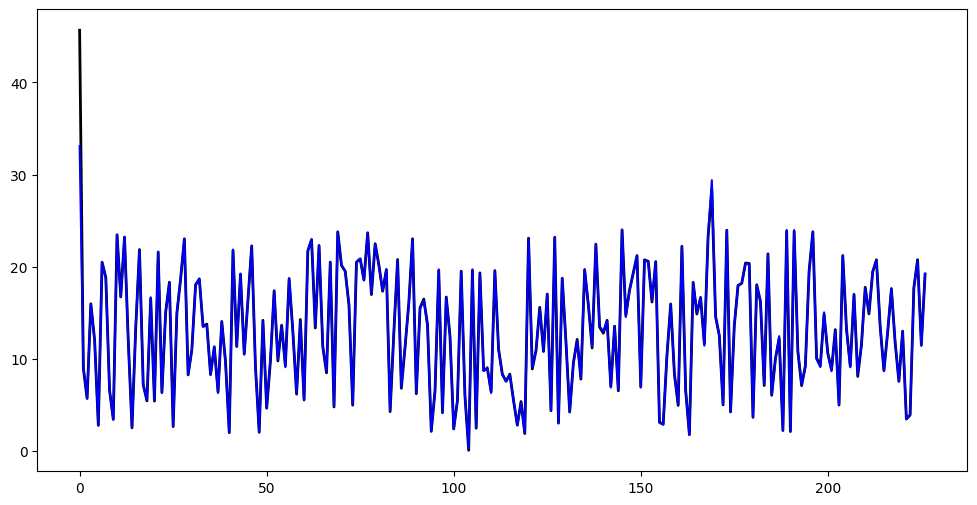

In [5]:
# 4. Visualization of Prediction Intervals
# -------------------------------
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="True", color="black", linewidth=2)
plt.plot(preds[0.5], label="Median Prediction", color="blue")


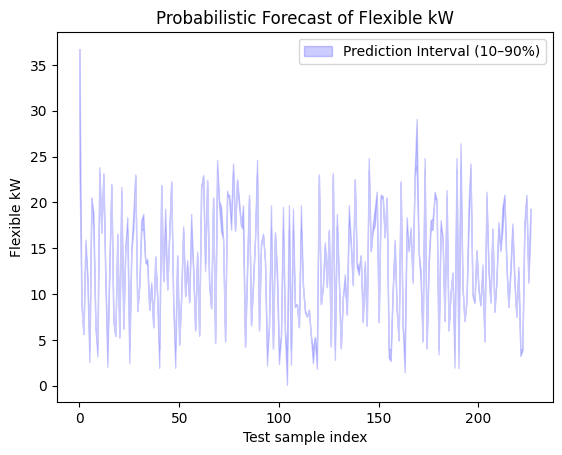

In [6]:
# Shaded interval between 10% and 90% quantiles
plt.fill_between(range(len(y_test)), preds[0.1], preds[0.9], color="blue", alpha=0.2, label="Prediction Interval (10–90%)")

plt.title("Probabilistic Forecast of Flexible kW")
plt.xlabel("Test sample index")
plt.ylabel("Flexible kW")
plt.legend()
plt.show()

In [7]:
# -------------------------------
# AFTER training quantile models and producing preds dict
# preds is a dict: preds[0.1], preds[0.5], preds[0.9]
# and y_test is the test targets from train_test_split
# -------------------------------

import os

# ensure results folder exists
os.makedirs("../results", exist_ok=True)

# Convert preds to plain numpy arrays (just to be safe)
preds_np = {q: np.asarray(preds[q]) for q in preds}

# Save as numpy (allow_pickle) so we can reload the dict structure
np.save("../results/probabilistic_preds.npy", preds_np, allow_pickle=True)

# Save y_test values (aligned order!)
np.save("../results/y_test.npy", np.asarray(y_test), allow_pickle=True)

# Also save a CSV with columns: True, Q10, Q50, Q90 (handy to inspect)
df_preds = pd.DataFrame({
    "True": np.asarray(y_test),
    "Q10": preds_np[0.1],
    "Q50": preds_np[0.5],
    "Q90": preds_np[0.9]
})
df_preds.to_csv("../results/probabilistic_predictions.csv", index=False)

print("Saved ../results/probabilistic_preds.npy, ../results/y_test.npy, ../results/probabilistic_predictions.csv")


Saved ../results/probabilistic_preds.npy, ../results/y_test.npy, ../results/probabilistic_predictions.csv
